In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from decord import VideoReader

In [2]:
video_path = r"path_to_videos/\A{i}B{j}.mp4"

In [3]:
vr = VideoReader(video_path)
frame = vr.next()
frame = frame.asnumpy()
del(vr)

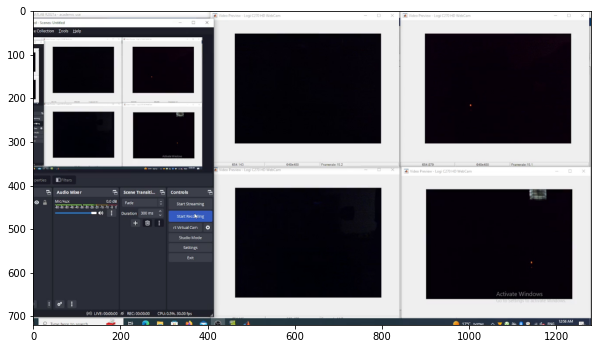

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(frame)

In [5]:
frame.shape # [y, x]

(720, 1280, 3)

In [6]:
def split_frame_to_cameras(frame):
    # take only red channel
    top_left = frame[100:250, 510:750, 0]  
    top_right = frame[100:250, 950:1100, 0]
    bottom_left = frame[445:600, 510:750, 0] 
    bottom_right = frame[445:600, 950:1100, 0]  
    return top_left, top_right, bottom_left,  bottom_right

In [7]:
vr = VideoReader(video_path)
cal_tr, cal_tl, cal_br, cal_bl = [], [], [], []

for i in range(300):
    f = vr.next().asnumpy()
    tl, tr, bl, br = split_frame_to_cameras(f)
    cal_tr.append(tr)
    cal_tl.append(tl)
    cal_br.append(br)
    cal_bl.append(bl)
del(vr)

In [8]:
bl_baseline = np.array(cal_bl).mean(axis=0)
br_baseline = np.array(cal_br).mean(axis=0)
tl_baseline = np.array(cal_tl).mean(axis=0)
tr_baseline = np.array(cal_tr).mean(axis=0)

In [9]:
def detect(arr):
    return arr[arr > np.percentile(arr, 80)].sum()

In [10]:
vr = VideoReader(video_path)
I_tr, I_tl, I_br, I_bl = [], [], [], []
raw_br, raw_tr = [], []

for i in range(len(vr)//2):
    f = vr.next().asnumpy()
    vr.skip_frames(1)
    tl, tr, bl, br = split_frame_to_cameras(f)
    tl, tr, bl, br = tl.astype(float), tr.astype(float), bl.astype(float), br.astype(float)
    
    raw_br.append(br.sum())
    raw_tr.append(tr.sum())
    
    tl -= tl_baseline
    tr -= tr_baseline
    bl -= bl_baseline
    br -= br_baseline
    I_tr.append(detect(tr))
    I_tl.append(detect(tl))
    I_br.append(detect(br))
    I_bl.append(detect(bl))
    

del(vr)

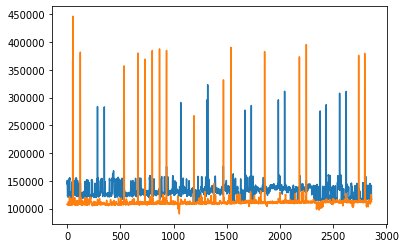

In [11]:
plt.plot(raw_tr)
plt.plot(raw_br)

In [12]:
def ewma(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def denoise_signal(sig):
    sig = np.array(sig)
#     sig = (sig - sig.min()) / (sig.max() - sig.min())
    return sig - ewma(sig, 200)

In [13]:
tl_sig = denoise_signal(I_tl)
tr_sig = denoise_signal(I_tr)
bl_sig = denoise_signal(I_bl)
br_sig = denoise_signal(I_br)

<AxesSubplot:>

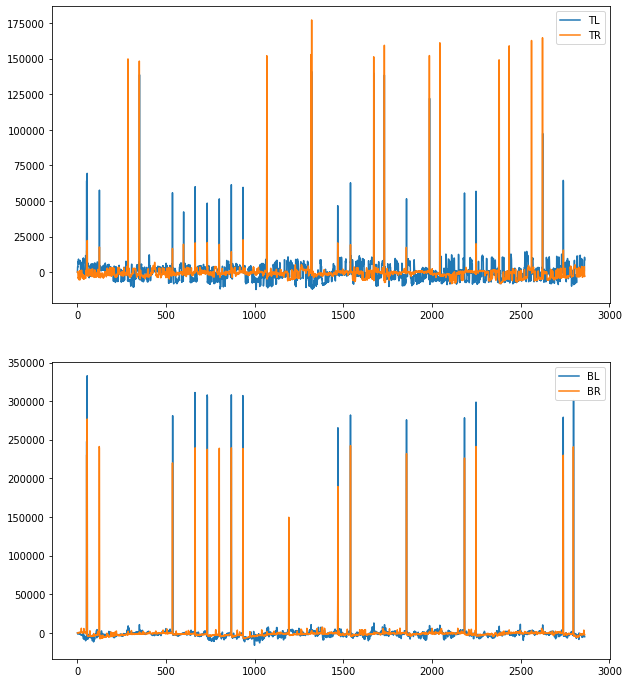

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(tl_sig, label="TL", ax=ax1)
sns.lineplot(tr_sig, label="TR", ax=ax1)
sns.lineplot(bl_sig, label="BL", ax=ax2)
sns.lineplot(br_sig, label="BR", ax=ax2)

In [15]:
top_threshold = 75000#0.5
bottom_threshold = 75000#0.4

tl_detections = tl_sig > top_threshold
tr_detections = tr_sig > top_threshold

bl_detections = bl_sig > bottom_threshold
br_detections = br_sig > bottom_threshold

total_detections = ((tl_detections & tr_detections) | (bl_detections & br_detections)).sum()
print(total_detections)

18


In [16]:
min_frame_diff = 5
def merge_close_detections(detections, signal):
    # detections: Bool, (num_frames,)
    candidate_frames = np.concatenate((np.where(detections)[0], [0])) # concat [0] in the end to get the final detection as jump
#     candidate_frames = np.where(detections)[0]
    frame_diffs = np.ediff1d(candidate_frames)
    jumps = np.argwhere(frame_diffs>min_frame_diff).reshape(-1)
    print(jumps)
    signal_samples = []
    for i in range(jumps.shape[0]):
        start = jumps[i]
        end = jumps[i+1] if i+1 < len(jumps) else len(candidate_frames)
        frames = candidate_frames[start:end]
        signal_samples.append(signal[frames].mean())
    
    clean_signal = np.zeros_like(signal)
    clean_signal[candidate_frames[jumps]] = signal_samples
    return clean_signal

def get_simul_signals(t_clean, b_clean, time_diff_threshold=20):
    t_clean_det = np.argwhere(t_clean > 0)
    b_clean_det = np.argwhere(b_clean > 0)

    diff_mat = np.subtract.outer(t_clean_det, b_clean_det).reshape((t_clean_det.shape[0], b_clean_det.shape[0]))

    t_diff_from_b = np.abs(diff_mat).min(axis=1) 
    b_diff_from_t = np.abs(diff_mat).min(axis=0)

    t_simul_det = t_clean_det[t_diff_from_b < time_diff_threshold].reshape(-1)
    b_simul_det = b_clean_det[b_diff_from_t < time_diff_threshold].reshape(-1)

    print(f"t detections: {t_simul_det.shape}, b detections: {b_simul_det.shape}")

    t_simul_sig, b_simul_sig = np.zeros_like(t_clean), np.zeros_like(b_clean)
    t_simul_sig[t_simul_det] = t_clean[t_simul_det]
    b_simul_sig[b_simul_det] = b_clean[b_simul_det]
    return t_simul_sig, b_simul_sig

In [17]:
tl_clean = merge_close_detections(tl_detections, tl_sig)
tr_clean = merge_close_detections(tr_detections, tr_sig)
bl_clean = merge_close_detections(bl_detections, bl_sig)
br_clean = merge_close_detections(br_detections, br_sig)

[ 0  1  2  4  5  6  7  9 10]
[ 0  1  2  4  5  6  7  8 10 11 12]
[ 1  2  3  5  6  8  9 10 11 12 13 14]
[ 1  3  4  5  6  7  8 10 12 13 14 15 16 17 18]


In [18]:
tl_clean, tr_clean = get_simul_signals(tl_clean, tr_clean)
bl_clean, br_clean = get_simul_signals(bl_clean, br_clean)

t detections: (9,), b detections: (9,)
t detections: (12,), b detections: (12,)


In [20]:
br_clean = np.roll(br_clean, 1)

In [19]:
np.argwhere(br_clean>0), np.argwhere(bl_clean>0)

(array([[  55],
        [ 536],
        [ 664],
        [ 732],
        [ 868],
        [ 934],
        [1469],
        [1540],
        [1856],
        [2183],
        [2248],
        [2740]], dtype=int64), array([[  55],
        [ 537],
        [ 663],
        [ 733],
        [ 868],
        [ 934],
        [1469],
        [1540],
        [1856],
        [2183],
        [2248],
        [2740]], dtype=int64))

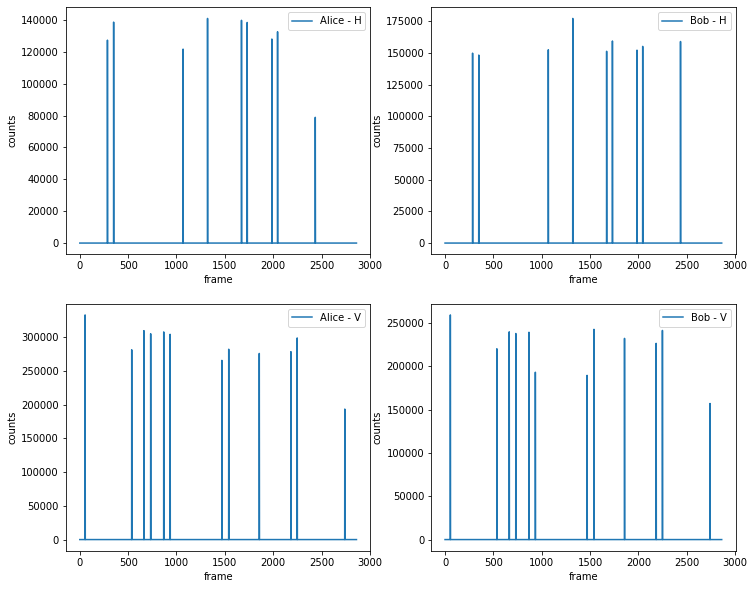

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(tl_clean, label="Alice - H", ax=ax1)
sns.lineplot(tr_clean, label="Bob - H", ax=ax2)
sns.lineplot(bl_clean, label="Alice - V", ax=ax3)
sns.lineplot(br_clean, label="Bob - V", ax=ax4)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("frame")
    ax.set_ylabel("counts")
fig.suptitlep = "QST - 10 Bits"
plt.show()

In [23]:
tl_clean[tl_clean>0].mean(), tr_clean[tr_clean>0].mean(), bl_clean[bl_clean>0].mean(), br_clean[br_clean>0].mean()

(128842.34977510596, 140743.82852196557, 227401.0534257065, 228887.47575844667)

In [24]:
def get_density(sig1, sig2):
    mask = (sig1>0)|(sig2>0)
    sig1_norm = sig1 / (2*max(np.concatenate([sig1, sig2])))
    sig2_norm = sig2 / (2*max(np.concatenate([sig1, sig2])))
    
    return (sig1_norm[mask] * sig2_norm[mask]).sum()


In [25]:
get_density(tr_clean, tl_clean)

0.6223772104237582

In [26]:
P_VV = get_density(bl_clean, br_clean)
P_VH = get_density(bl_clean, tr_clean)
P_HV = get_density(tl_clean, br_clean)
P_HH = get_density(tl_clean, tr_clean)

In [27]:
P_VV, P_HH, P_VH, P_HV

(1.2784519827899625, 0.6223772104237582, 0.0, 0.0)

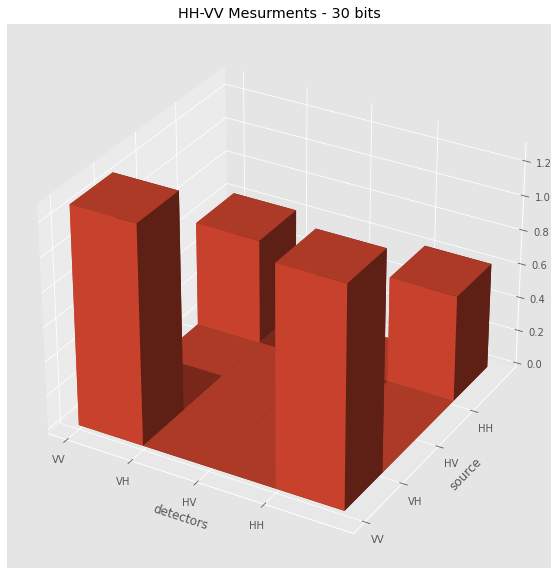

In [29]:
send_basis = ["VV", "VH", "HV", "HH"]
HH_VV_mat = np.zeros((len(send_basis), len(send_basis)))

HH_VV_mat[[0,-1]] = np.array([P_VV, P_VH, P_HV, P_HH]) 

mat = HH_VV_mat
x = []
y = []
dz = []
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        x.append(i)
        y.append(j)
        dz.append(mat[i, j])

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
style.use('ggplot')

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

z3 = [0, 0, 0, 0]*4

dx = np.ones(16)
dy = np.ones(16)
# dz = HH_VV_mat.flatten()

ax1.bar3d(x, y, z3, dx, dy, dz)

ax1.set_xticks(range(len(send_basis)))
ax1.set_yticks(range(len(send_basis)))

ax1.set_xticklabels(send_basis)
ax1.set_yticklabels(send_basis)

ax1.set_xlabel('detectors')
ax1.set_ylabel('source')
ax1.set_title(f"HH-VV Mesurments - 30 bits")

plt.show()